In [2]:
###################### Importing Packages #########################################
import os

import numpy as np
import pickle, random, time
from sklearn import svm
from itertools import chain, combinations
from copy import deepcopy
from sklearn.decomposition import PCA
import pandas as pd
import nibabel as nib

from datautility import *

from scipy.stats import kurtosis, moment, skew, entropy
from tqdm import tqdm
from scipy.io import savemat, loadmat

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Read and Save prefrontal mask
* compress nii to mat
* separate left prefrontal and right prefrontal area

In [ ]:
path1 = './data/masks/JHU-ICBM-labels-1mm_7ROI_edits.nii'
path2 = './data/masks/JHU-ICBM-labels-1mm_7ROI.nii'

mask1 = ((nib.load(path1)).get_fdata()).astype(np.float32)
mask2 = ((nib.load(path2)).get_fdata()).astype(np.float32)

print(mask1.shape)
print (np.sum ((mask1 == mask2).astype(np.float32)), mask1.shape[0]*mask1.shape[1]*mask1.shape[2])

In [3]:
PATH = './data/prior_cycle_subj_space_metrics_and_masks/mask_mat/' + 'HT102_cc_body_mask_b0_fa.mat'
data = loadmat(PATH)
print(data['vol'].shape)

PATH = './data/current_cycle_subj_space_metrics_and_masks/metrics_mat/' + 'WMTI_eas_De_par_TBN021.nii'
data = loadmat(PATH)
print(data['vol'].shape)

PATH = './data/current_cycle_subj_space_metrics_and_masks/mask_mat/' + 'TBI001_cc_body_mask_b0_fa.mat'
data = loadmat(PATH)
print(data['vol'].shape)

(82, 82, 28)
(88, 88, 54)
(88, 88, 54)


## Defining Global Variable
* 12 channels of metrics to use: [ad, ak, awf, eas_De_par, eas_De_perp, eas_tort, FA, ias_Da, md, mk, rd, rk]
* 5 region mask: [1_L_thal, 2_R_thal, CC_Body_mask, CC_Genu_mask, CC_Splenium_mask]
* 67 positive index and 50 negative index in 117 new subjects 
* 27 positive index and 22 negative index in 49 old subjects

In [4]:
###################### Importing Packages #########################################
# metric = ['ad', 'ak', 'awf', 'eas_De_par', 'eas_De_perp', 'eas_tort', 'FA', 'ias_Da', 'md', 'mk', 'rd', 'rk']
# 12 metrics in total

whichmask = 'old'

metric = ['ak', 'awf', 'eas_De_par', 'eas_De_perp', 'FA', 'ias_Da', 'md', 'mk']
# 8 metric to use, proposed by Alp
if whichmask == 'new':
    mask_name = ['left_rostral','right_rostral','left_middle','right_middle','left_caudal', 'right_caudal', 'corpus_callosum']
# we do not have prefrontal mask for subject space
else:
    mask_name = ['cc_body', 'cc_genu', 'cc_splenium', 'thal']
    
NEW_PATH = './data/117_Stats_Rep.xls'

new_data = pd.read_excel(NEW_PATH, header=0, index_col=0, sheet_name=0)
new_idx_ori = list(new_data.index)

new_idx = [i[3:-4] for i in new_idx_ori]
new_idx = new_idx[:-60] + new_idx[-50:-12] # filter mask currently

print(new_idx, len(new_idx))

# should be 50 negative in total

OLD_PATH = './data/old_65subj_stats JFR.xlsx'

old_data = pd.read_excel(OLD_PATH, header=0, index_col=0, sheet_name=0)
old_idx = list(old_data.index)

old_index = np.arange(65)
old_index = np.delete(old_index, [1, 4, 6, 8, 10, 12, 14, 16, 21, 23, 26, 29, 33, 35, 37, 43])

print(old_idx)

# And 49 old subjects 

stats = [np.mean, np.std, skew, kurtosis, entropy] # mean, std, normalize 3rd moment, normalized 4th moment, entrophy 
stats_str = ['mean', 'std', 'skew', 'kurt', 'etrp'] # mean, std, normalize 3rd moment, normalized 4th moment, entrophy 

['TBI001', 'TBI002', 'TBI003', 'TBI004', 'TBI005', 'TBI006', 'TBI007', 'TBI008', 'TBI010', 'TBI011', 'TBI012', 'TBI013', 'TBI014', 'TBI015', 'TBI019', 'TBI020', 'TBI021', 'TBI022', 'TBI023', 'TBI024', 'TBI025', 'TBI026', 'TBI027', 'TBI028', 'TBI029', 'TBI031', 'TBI032', 'TBI033', 'TBI035', 'TBI036', 'TBI037', 'TBI038', 'TBI039', 'TBI040', 'TBI041', 'TBI042', 'TBI043', 'TBI044', 'TBI045', 'TBI046', 'TBI047', 'TBI048', 'TBI049', 'TBI050', 'TBI051', 'TBI052', 'TBI053', 'TBI054', 'TBI055', 'TBI056', 'TBI057', 'TBI058', 'TBI059', 'TBI060', 'TBI061', 'TBI062', 'TBI063', 'TBN001', 'TBN002', 'TBN003', 'TBN004', 'TBN005', 'TBN006', 'TBN007', 'TBN008', 'TBN009', 'TBN010', 'TBN011', 'TBN012', 'TBN013_2', 'TBN014_2', 'TBN018', 'TBN019', 'TBN020', 'TBN021', 'TBN022', 'TBN023', 'TBN024', 'TBN025', 'TBN026', 'TBN027', 'TBN028', 'TBN029', 'TBN030', 'TBN031', 'TBN032', 'TBN033', 'TBN034', 'TBN035', 'TBN036', 'TBN037', 'TBN038', 'TBN039', 'TBN040', 'TBN041'] 95
['HT102', 'HT103', 'HT105', 'HT106', 'HT10

C:\Users\maton\AppData\Local\conda\conda\envs\cs231\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


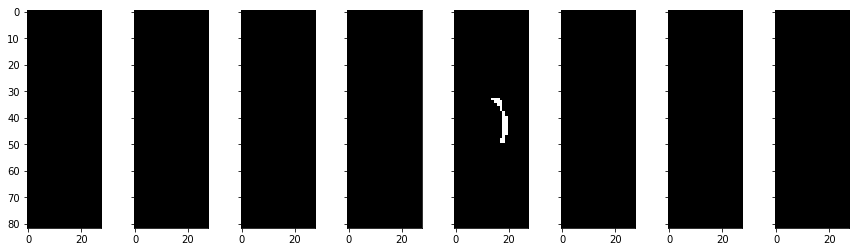

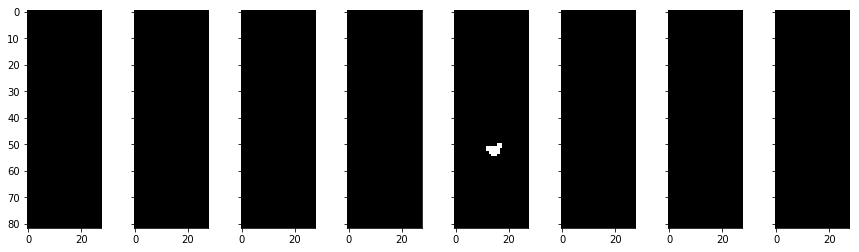

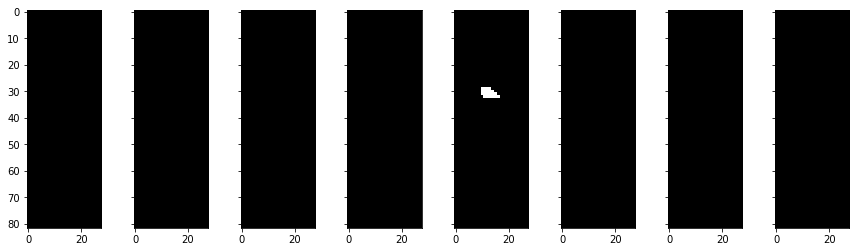

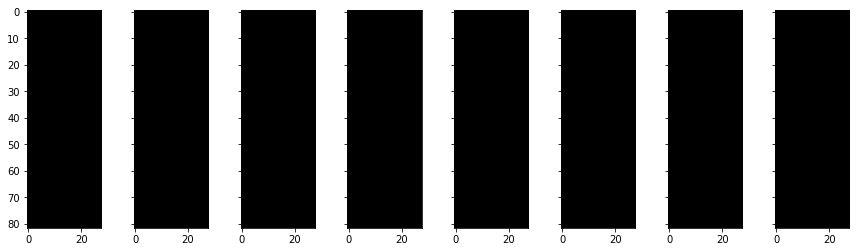

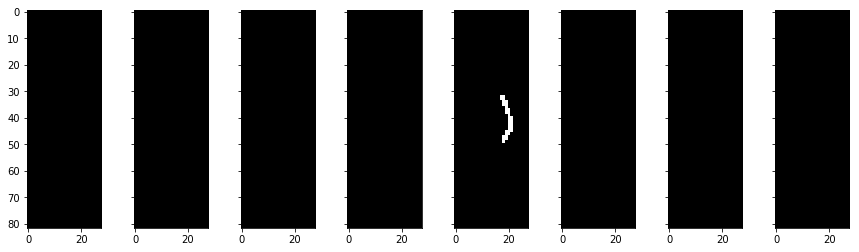

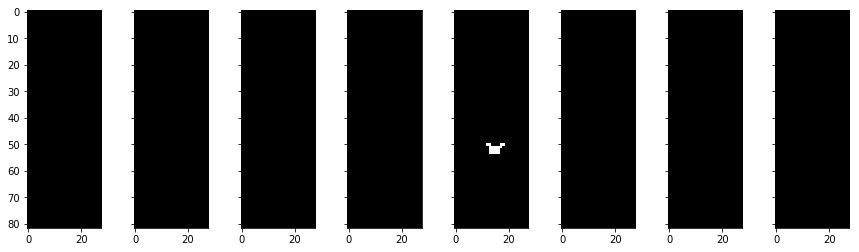

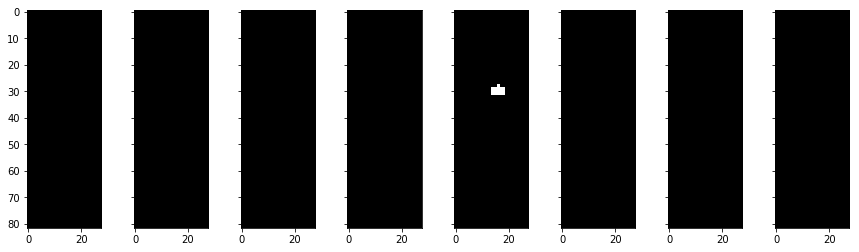

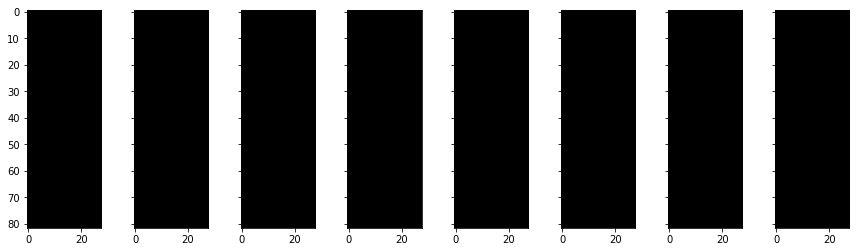

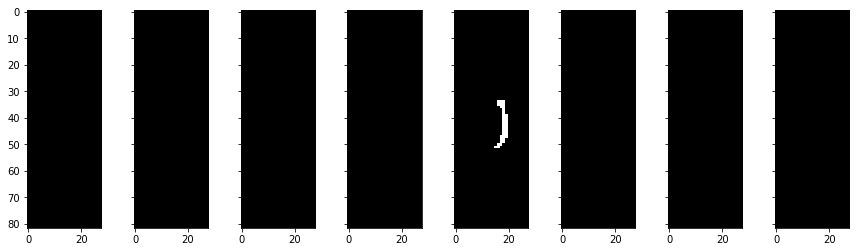

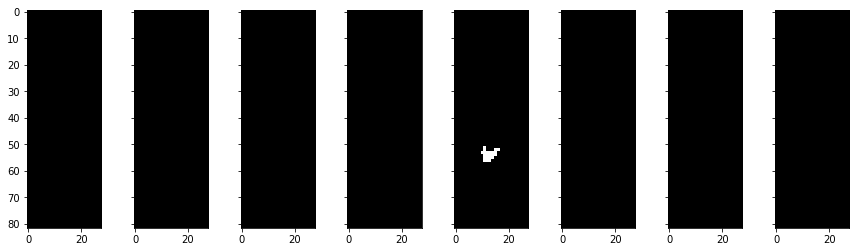

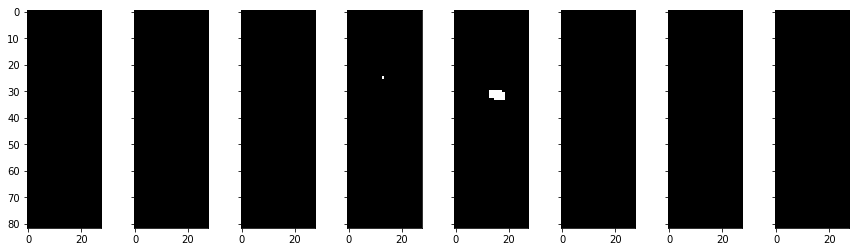

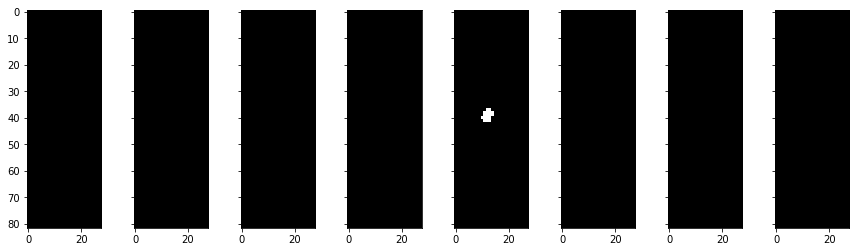

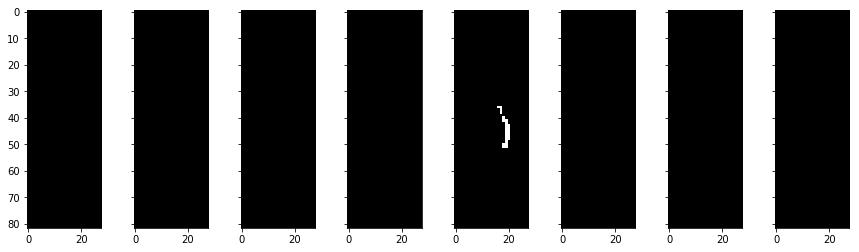

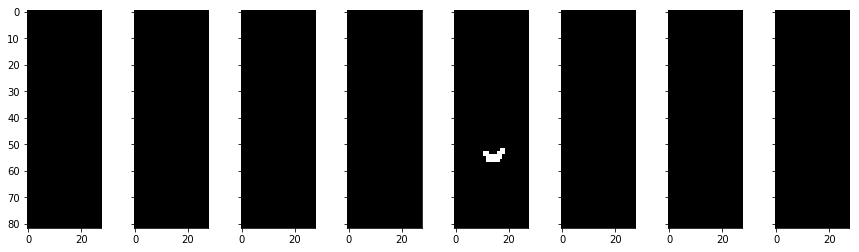

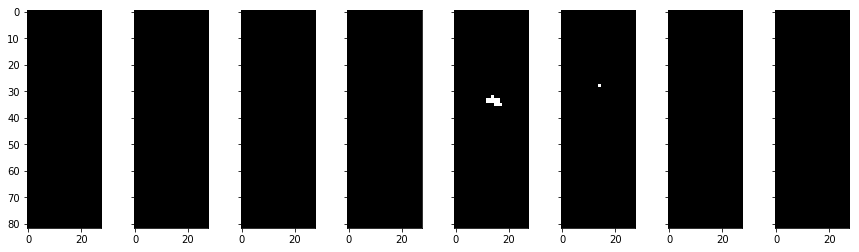

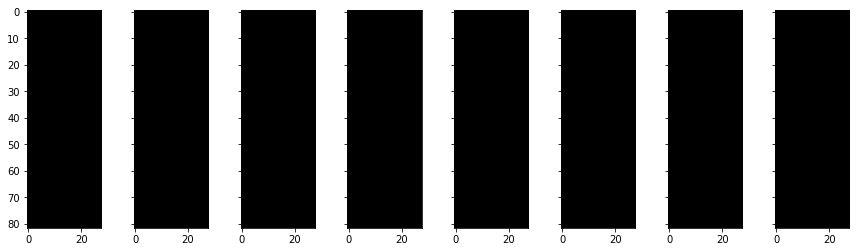

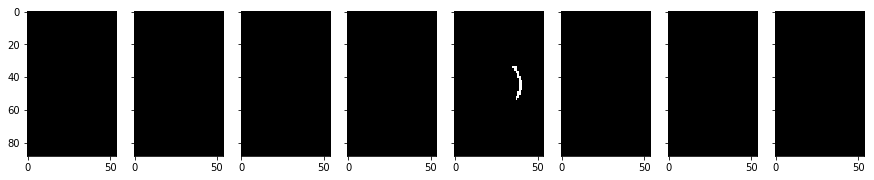

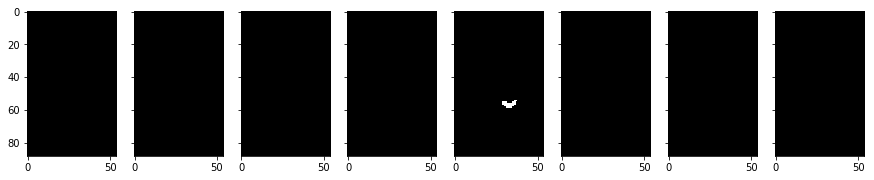

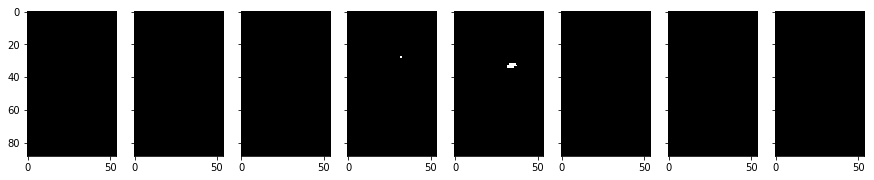

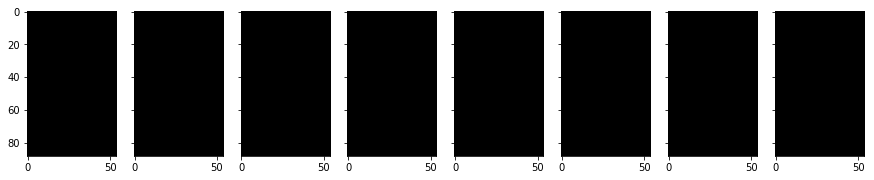

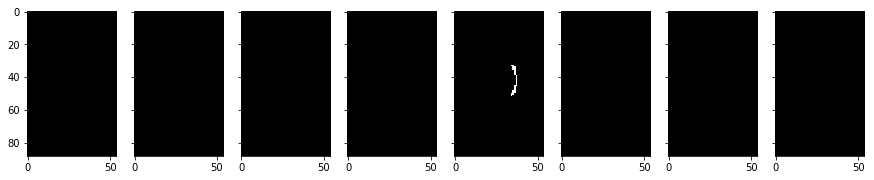

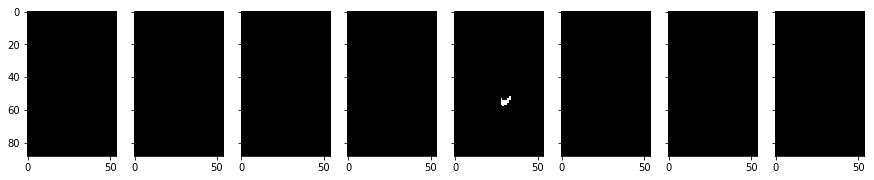

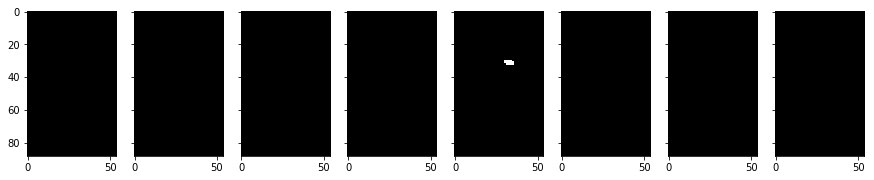

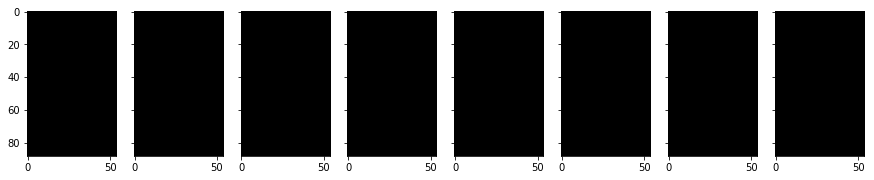

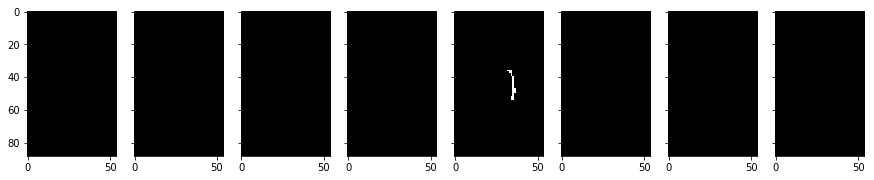

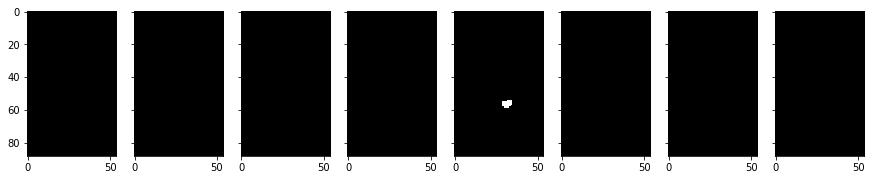

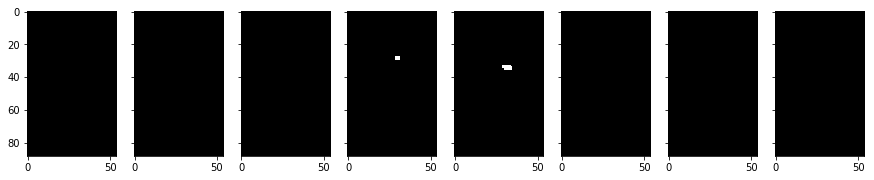

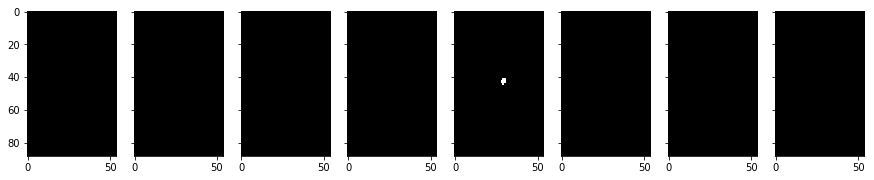

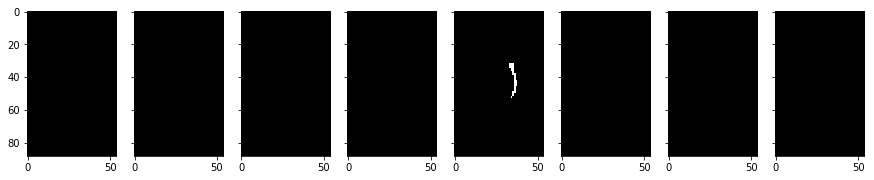

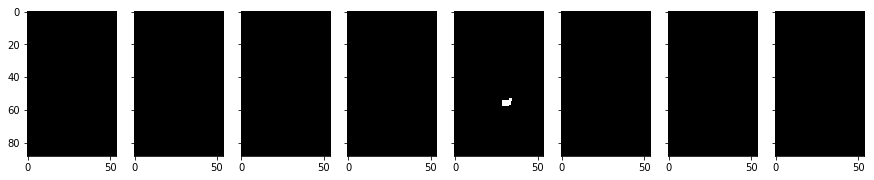

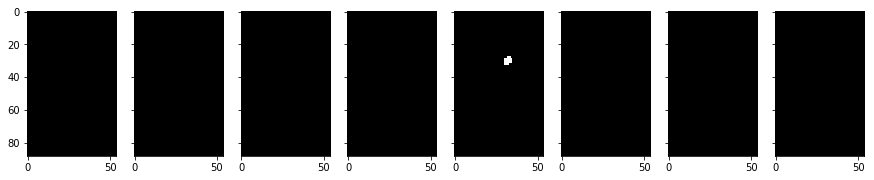

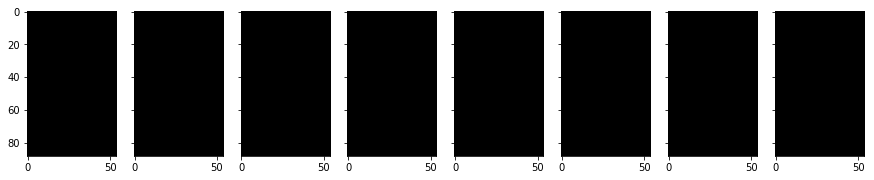

In [7]:
for i, oname in enumerate(old_idx):
    data = get_mask_subject(oname, mask_name, 'old', mask_type=whichmask, verbose=True)
    if i == 3:
        break
        
for i, name in enumerate(new_idx):
    data = get_mask_subject(name, mask_name, 'new', mask_type=whichmask, verbose=True)
    if i == 3:
        break

In [ ]:
for i, oname in enumerate(old_idx):
    data = get_image_subject(oname, metric, 'old', verbose=True)
    if i == 3:
        break
        
for i, name in enumerate(new_idx):
    data = get_image_subject(name, metric, 'new', verbose=True)
    if i == 3:
        break

## Generating 117 new subjects
* each subject has a feature vector of shape (360,)

In [9]:
# Generating new subject space data

data_new = []
key_new = []

for name in tqdm(new_idx):
    
    data = get_image_subject(name, metric, 'new', verbose=False)
    temp = np.zeros([len(metric), len(mask_name), len(stats)])
    mask = get_mask_subject(name, mask_name, 'new', mask_type=whichmask, verbose=False)
    
    for i, m in enumerate(data): # for metric in data
        for j, k in enumerate(mask): # for mask in mask
            mask_data = (m*k).reshape(-1)
            mask_data = mask_data[mask_data != 0]
            for t, s in enumerate(stats):
                temp[i,j,t] = s(mask_data)
                
    temp = temp.reshape(-1) # a C style flattening, metric*mask*stats
    data_new.append(temp)
    
    key_new.append(name[:-3] + '-' + name[-3:])
    
print('loading {} new subjects'.format(len(new_idx)))

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:23<00:00,  4.08it/s]


loading 95 new subjects


## Generating 49 subjects among 67 old images
* Other 18 subjects are take MRI second time, ignore them for this dataset

In [10]:
data_old = []
key_old = []

for name in tqdm(old_idx):
    # iter only the key is enough
    data = get_image_subject(name, metric, 'old', verbose=False)
    temp = np.zeros([len(metric), len(mask_name), len(stats)])
    mask = get_mask_subject(name, mask_name, 'old', mask_type=whichmask, verbose=False)

    for i, m in enumerate(data): # for metric in data
        for j, k in enumerate(mask): # for mask in mask
            mask_data = (m*k).reshape(-1)
            mask_data = mask_data[mask_data != 0]

            for t, s in enumerate(stats):
                temp[i,j,t] = s(mask_data)
    temp = temp.reshape(-1) # a C style flattening, metric*mask*stats
    data_old.append(temp)
    key_old.append(name)
    
print('loading {} old subjects'.format(len(data_old)))

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:08<00:00,  5.81it/s]


loading 49 old subjects


## Binding data
* Sequence: old subjects -> positive new subjects -> negative new subjects
* Generate column names as statistic * mask * metric

In [11]:
data_all = []
key_all = []

data_all = data_old + data_new
key_all = key_old + key_new

print(len(data_all), data_all[0].shape)

144 (160,)


In [12]:
import itertools

pre_column = ['-'.join(i) for i in list(itertools.product(mask_name, stats_str))]
index_column = ['-'.join(i) for i in list(itertools.product(metric, pre_column))] # metric

In [13]:
data_dict = pd.DataFrame(data=data_all, index=key_all, columns=index_column)
print(data_dict.index, len(key_all), len(index_column))
####################### Save dataframe to Excel #############################################

SAVE_PATH = './data/stats_data_gather_' + str(whichmask) + '_subjectspace' + '.xlsx'
if not os.path.isfile(SAVE_PATH):
    data_dict.to_excel(SAVE_PATH)
    pass
else:
    print('file {} exists'.format(SAVE_PATH))

Index(['HT102', 'HT103', 'HT105', 'HT106', 'HT107', 'HT109', 'HT111', 'HT112',
       'HT113', 'HT114',
       ...
       'TBN-032', 'TBN-033', 'TBN-034', 'TBN-035', 'TBN-036', 'TBN-037',
       'TBN-038', 'TBN-039', 'TBN-040', 'TBN-041'],
      dtype='object', length=144) 144 160


In [14]:
LABEL_PATH = './data/merged_np.xlsx'
label_data = pd.read_excel(LABEL_PATH, index_col=1, sheet_name=0)
print(label_data.index, label_data.columns)

DATA_PATH = './data/stats_data_gather_' + str(whichmask) + '_subjectspace' + '.xlsx'
stats_data = pd.read_excel(DATA_PATH, index_col=0, sheet_name=0)
print(stats_data.index, stats_data.columns)

Index(['HT102', 'HT103', 'HT104', 'HT105', 'HT106', 'HT107', 'HT108', 'HT109',
       'HT110', 'HT111',
       ...
       'TBN-043', 'TBN-044', 'TBN-045', 'TBN-046', 'TBN-047', 'TBN-049',
       'TBN-050', 'TBN-051', 'TBN-052', 'TBN-053'],
      dtype='object', name='Subject', length=172) Index(['Unnamed: 0', 'T1 Letter Number', 'T2 Letter Number',
       'T3 Letter Number', 'Digit Span Forward T1', 'Digit Span Forward T2',
       'Digit Span Forward T3', 'Digit Span Backward T1',
       'Digit Span Backward T2', 'Digit Span Backward T3', 'Trailmaking B T1',
       'Trailmaking B T2', 'Trailmaking B T3', 'Trailmaking A T1',
       'Trailmaking A T2', 'Trailmaking A T3', 'CVLT T1', 'CVLT T2', 'CVLT T3',
       'RCFT Immediate T1', 'RCFT Immediate T2', 'RCFT Immediate T3',
       'RCFT Delayed T1', 'RCFT Delayed T2', 'RCFT Delayed T3', 'DKEFS T1',
       'DKEFS T2', 'DKEFS T3', 'Stroop T1', 'Stroop T2', 'Stroop T3',
       'SDMT T1', 'SDMT T2', 'SDMT T3'],
      dtype='object')
Index(['H

In [15]:
all_data = pd.concat([data_dict, label_data], axis=1, join='inner')
print(all_data)

         ak-cc_body-mean  ak-cc_body-std  ak-cc_body-skew  ak-cc_body-kurt  \
HT102           0.589495        0.193305         1.369944         2.558925   
HT103           0.568423        0.137815         1.947823         7.327775   
HT105           0.509716        0.160253        -0.132026         0.938205   
HT106           0.555993        0.160949         1.821087         4.843239   
HT107           0.503580        0.191604         0.399759         0.639163   
HT109           0.655850        0.200738         1.440432         2.344460   
HT111           0.523790        0.179724         0.987238         1.524606   
HT112           0.556118        0.169083         1.255838         2.917737   
HT113           0.629300        0.176069         1.556035         3.564879   
HT114           0.555052        0.156029         1.635902         8.197748   
HT115           0.574742        0.181084         1.472551         2.857219   
HT116           0.507027        0.168811         1.452977       

[132 rows x 194 columns]


In [16]:
reduce_data = all_data.iloc[:,0:data_all[0].shape]
print(reduce_data.columns, reduce_data.index)

reduce_label = all_data.iloc[:,data_all[0].shape:]
print(reduce_label.columns, reduce_label.index)

Index(['ak-cc_body-mean', 'ak-cc_body-std', 'ak-cc_body-skew',
       'ak-cc_body-kurt', 'ak-cc_body-etrp', 'ak-cc_genu-mean',
       'ak-cc_genu-std', 'ak-cc_genu-skew', 'ak-cc_genu-kurt',
       'ak-cc_genu-etrp',
       ...
       'mk-cc_splenium-mean', 'mk-cc_splenium-std', 'mk-cc_splenium-skew',
       'mk-cc_splenium-kurt', 'mk-cc_splenium-etrp', 'mk-thal-mean',
       'mk-thal-std', 'mk-thal-skew', 'mk-thal-kurt', 'mk-thal-etrp'],
      dtype='object', length=160) Index(['HT102', 'HT103', 'HT105', 'HT106', 'HT107', 'HT109', 'HT111', 'HT112',
       'HT113', 'HT114',
       ...
       'TBN-032', 'TBN-033', 'TBN-034', 'TBN-035', 'TBN-036', 'TBN-037',
       'TBN-038', 'TBN-039', 'TBN-040', 'TBN-041'],
      dtype='object', length=132)
Index(['Unnamed: 0', 'T1 Letter Number', 'T2 Letter Number',
       'T3 Letter Number', 'Digit Span Forward T1', 'Digit Span Forward T2',
       'Digit Span Forward T3', 'Digit Span Backward T1',
       'Digit Span Backward T2', 'Digit Span Backward 

In [17]:
savepath = 'data_132_' + str(whichmask) + '_subjectspace'+ '.xlsx'

if not os.path.isfile(savepath):
    reduce_data.to_excel(savepath)
    print('new data file generated')
else:
    print('file exist, check the disk')

labelpath = 'label_132_' + str(whichmask) + '_subjectspace'+ '.xlsx'
if not os.path.isfile(labelpath):
    reduce_label.to_excel(labelpath)
    print('new label file generated')
else:
    print('file exist, check the disk')

new data file generated
new label file generated
